# Car Evaluation. Random Forest 

## Table of Content

1. [Introduction](#Introduction)
    1. [Data Description](#Data_Description)
    2. [Columns Description](#Columns_Description)
    3. [Project Objective](#Project_Objective)
2. [Fetching Data](#Fetching_Data)
3. [Preprocessing Data](#Preprocessing_Data)
4. [Bagging & Decision Tree](#Bagging_DecisionTree)
5. [Random Forest](#RandomForest)
6. [Extremely Randomized Trees](#Extremely_Randomized_Trees)
7. [Hyperparameters tuning](#Hyperparameter_Tuning)
    1. [Validation Curves](#Validation_Curves)
    2. [Randomized Search CV](#RandomizedSearchCV)
    3. [Grid Search CV](#GridSearchCV)
8. [Feature importance visualization](#Feature_Importance)
9. [Conclusion](#Conclusion)

<a id='Introduction'></a>

## 1. Introduction

<a id='Data_Description'></a>

### Data Description

[Car Evaluation](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure:

CAR car acceptability
- PRICE overall price
    - buying buying price
    - maint price of the maintenance
- TECH technical characteristics
    - COMFORT comfort
        - doors number of doors
        - persons capacity in terms of persons to carry
        - lug_boot the size of luggage boot
    - safety estimated safety of the car

Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a set of examples.

The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: `buying`, `maint`, `doors`, `persons`, `lug_boot`, `safety`.

Because of known underlying concept structure, this database may be particularly useful for testing constructive induction and structure discovery methods.

<a id='Columns_Description'></a>

### Columns Description

- *buying* - buying price. Values:
    - vhigh
    - high
    - med
    - low
- *maint* -  price of the maintenance. Values: 
    - vhigh
    - high
    - med
    - low
- *doors* -  number of doors. Values: 
    - 2
    - 3
    - 4
    - 5more
- *persons* - capacity in terms of persons to carry. Values:
    - 2
    - 4
    - more
- *lug_boot* - the size of luggage boot. Values:
    - small
    - med
    - big
- *safety* -  estimated safety of the car. Values:
    - low
    - med
    - high
- *class* - car acceptability. Target variable. Values:
    - unacc
    - acc
    - good
    - vgood

<a id='Project_Objective'></a>

### Project Objective 

Random forest model design. Hyperparameters tuning. Feature importance visualization.

<a id='Fetching_Data'></a>

## 2. Fetching Data

In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, validation_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from pprint import pprint

%matplotlib inline

In [2]:
column_names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety','class']

In [3]:
data = pd.read_csv('car.data', header=None, sep=',', names=column_names)

In [4]:
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,med,med,4,4,med,med,unacc
freq,432,432,432,576,576,576,1210


In [5]:
data['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

The dataset is highly imbalanced.

<a id='Preprocessing_Data'></a>

## 3. Preprocessing Data

In [6]:
X = data.drop(columns='class')
y = data['class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
233,vhigh,med,2,4,big,high
212,vhigh,high,5more,more,med,high
1273,med,low,5more,2,med,med
117,vhigh,high,2,4,small,low
848,high,low,5more,4,small,high


In [9]:
y_test.value_counts()

unacc    370
acc      112
good      19
vgood     18
Name: class, dtype: int64

In [10]:
def encode_column(X_train, X_test, col_name = None):
    #col_name = None for Series
    enc = LabelEncoder()
    
    if col_name: 
        enc.fit(X_train[col_name])
        X_train[col_name] = enc.transform(X_train[col_name])
        X_test[col_name] = enc.transform(X_test[col_name])
    else:
        # for y_train and y_test Series
        enc.fit(X_train)
        X_train = enc.transform(X_train)
        X_test = enc.transform(X_test)        
    return enc.classes_    

In [11]:
# dict for decoding
column_classes = {}

In [12]:
for col in column_names:
    if col == 'class':
        column_classes[col] = encode_column(y_train, y_test)
        continue            
    column_classes[col] = encode_column(X_train, X_test, col)

C:\Users\dinak\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dinak\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
233,3,2,0,1,0,0
212,3,0,3,2,1,0
1273,2,1,3,0,1,2
117,3,0,0,1,2,1
848,0,1,3,1,2,0


In [14]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision micro: \t {:.3f}\n" +\
                "Precision macro: \t {:.3f}\n" +\
                 "Recall micro: \t {:.3f}\n" +\
                "Recall macro: \t {:.3f}\n" +\
                 "f1_score micro: \t {:.3f}\n" +\
                "f1_score macro: \t {:.3f}\n"
    
    acc = accuracy_score(prediction, actual)
    precision_micro = precision_score(prediction, actual, average='micro')
    precision_macro = precision_score(prediction, actual, average='macro')
    recall_micro = recall_score(prediction, actual, average='micro')
    recall_macro = recall_score(prediction, actual, average='macro')
    f1_micro = f1_score(prediction, actual, average='micro')
    f1_macro = f1_score(prediction, actual, average='macro')    
    
    quality_list = [acc, precision_micro, precision_macro, recall_micro, recall_macro, f1_micro, f1_macro]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            accuracy_score(prediction, actual),
            precision_score(prediction, actual, average='micro'),
            precision_score(prediction, actual, average='macro'),
            recall_score(prediction, actual, average='micro'),
            recall_score(prediction, actual, average='macro'),
            f1_score(prediction, actual, average='micro'),
            f1_score(prediction, actual, average='macro')
        ))
        print("======================\n")
    
    return quality_list

<a id='Bagging_DecisionTree'></a>

## 4. Bagging & Decision Tree

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

quality_list_baseline = quality_report(y_pred, y_test)
df_quality = pd.DataFrame(
    [quality_list_baseline],
    columns=["Accuracy", "Precision micro", "Precision macro","Recall micro","Recall macro", "F1_micro", "F1_macro"],
    index=["bagging_500"]
)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.906
Precision micro: 	 0.906
Precision macro: 	 0.703
Recall micro: 	 0.906
Recall macro: 	 0.650
f1_score micro: 	 0.906
f1_score macro: 	 0.673




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.65,0.906,0.673


What if we reduce estimators count?

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=150, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

df_quality.loc["bagging_150", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.904
Precision micro: 	 0.904
Precision macro: 	 0.702
Recall micro: 	 0.904
Recall macro: 	 0.649
f1_score micro: 	 0.904
f1_score macro: 	 0.672




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672


What if we reduce max_features count?

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42, max_features = 5),
    n_estimators=400, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

df_quality.loc["bagging_400_max_features_5", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.898
Precision micro: 	 0.898
Precision macro: 	 0.659
Recall micro: 	 0.898
Recall macro: 	 0.669
f1_score micro: 	 0.898
f1_score macro: 	 0.657




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657


What if we apply balanced class weight?

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42, class_weight='balanced'),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

df_quality.loc["bagging_500_balanced_class", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.802
Precision micro: 	 0.802
Precision macro: 	 0.882
Recall micro: 	 0.802
Recall macro: 	 0.686
f1_score micro: 	 0.802
f1_score macro: 	 0.750




,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750


<a id='RandomForest'></a>

## 5. Random forest

Let it be baseline random forest model.

In [19]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

df_quality.loc["rf_500", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.894
Precision micro: 	 0.894
Precision macro: 	 0.641
Recall micro: 	 0.894
Recall macro: 	 0.658
f1_score micro: 	 0.894
f1_score macro: 	 0.648




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648


Let's reduce estimators count to 200.

In [20]:
rnd_clf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

df_quality.loc["rf_200", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.894
Precision micro: 	 0.894
Precision macro: 	 0.641
Recall micro: 	 0.894
Recall macro: 	 0.658
f1_score micro: 	 0.894
f1_score macro: 	 0.648




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648


Let's reduce estimators count to 100.

In [21]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

df_quality.loc["rf_100", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.894
Precision micro: 	 0.894
Precision macro: 	 0.641
Recall micro: 	 0.894
Recall macro: 	 0.646
f1_score micro: 	 0.894
f1_score macro: 	 0.643




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643


Let's build more trees with less depth.

In [22]:
rnd_clf = RandomForestClassifier(n_estimators=400, max_depth=5,  max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

df_quality.loc["rf_400_max_depth_5", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.846
Precision micro: 	 0.846
Precision macro: 	 0.412
Recall micro: 	 0.846
Recall macro: 	 0.386
f1_score micro: 	 0.846
f1_score macro: 	 0.398




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643
rf_400_max_depth_5,0.846,0.846,0.412,0.846,0.386,0.846,0.398


Let's build random forest with balanced class weight.

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, 
                                     random_state=42, class_weight='balanced')
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)

df_quality.loc["rf_100_balanced_class", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.871
Precision micro: 	 0.871
Precision macro: 	 0.900
Recall micro: 	 0.871
Recall macro: 	 0.728
f1_score micro: 	 0.871
f1_score macro: 	 0.793




,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643
rf_400_max_depth_5,0.846,0.846,0.412,0.846,0.386,0.846,0.398
rf_100_balanced_class,0.871,0.871,0.900,0.871,0.728,0.871,0.793


In [24]:
rnd_clf.feature_importances_

array([0.18065221, 0.13536015, 0.03245089, 0.1938761 , 0.16167905,
       0.29598161])

Making class weights balanced improves random forest quality significantly. Decreasing estimators count didn't improve model quality in our case.

<a id='Extremely_Randomized_Trees'></a>

## 6. Extremely Randomized Trees

In [25]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

df_quality.loc["extra_rand_tree_500", :] = quality_report(y_pred_ex, y_test)
df_quality.round(3)

0.8940269749518305
0.8131021194605009

=== Quality Report ===
Accuracy: 	 0.813
Precision micro: 	 0.813
Precision macro: 	 0.366
Recall micro: 	 0.813
Recall macro: 	 0.375
f1_score micro: 	 0.813
f1_score macro: 	 0.365




C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643
rf_400_max_depth_5,0.846,0.846,0.412,0.846,0.386,0.846,0.398
rf_100_balanced_class,0.871,0.871,0.900,0.871,0.728,0.871,0.793
extra_rand_tree_500,0.813,0.813,0.366,0.813,0.375,0.813,0.365


`RandomForestClassifier` has better result than `ExtraTreesClassifier`.

<a id = 'Hyperparameter_Tuning'></a>

## 7. Hyperparameters tuning

<a id='Validation_Curves'></a>

### Validation curves

In [26]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
def plot_validation_curve(X_train, y_train, param_name, param_range):
    train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(random_state=42),
                                X = X_train, y = y_train, 
                                param_name = param_name, 
                                param_range = param_range, cv = 3)
    train_scores_mean = np.mean(train_scoreNum, axis=1)
    train_scores_std = np.std(train_scoreNum, axis=1)
    test_scores_mean = np.mean(test_scoreNum, axis=1)
    test_scores_std = np.std(test_scoreNum, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

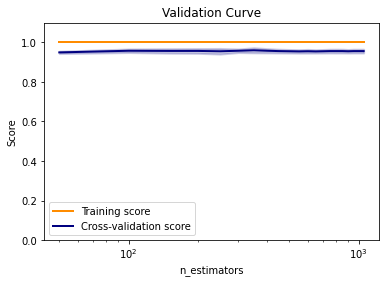

In [27]:
plot_validation_curve(X_train, y_train, 'n_estimators', np.arange(50, 1100, 50))

Due to validation curve `n_estimators` doesn't affect quality for random forest classifier with default parameter values.

C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

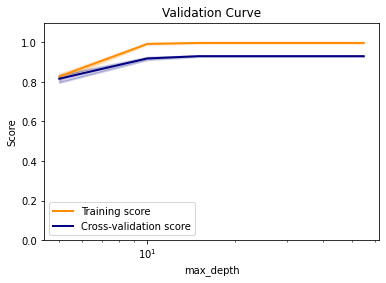

In [28]:
plot_validation_curve(X_train, y_train, 'max_depth', np.arange(5, 60, 5))

Due to validation curve `max_depth` best value is 10 for classifier default parameters.

C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dinak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

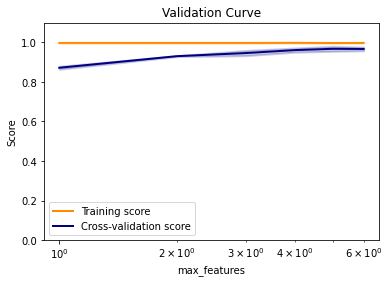

In [29]:
plot_validation_curve(X_train, y_train, 'max_features', np.arange(1, 7, 1))

Due to validation curve the `max_features` best value is 4 for classifier with default parameters.

The plots above are interesting but let's try to tune parameters via cross validation.

<a id='RandomizedSearchCV'></a>

### Randomized Search CV

In [30]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 99, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 122, 194, 266, 338, 411, 483, 555, 627, 700]}


In [31]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [32]:
rf_random.best_params_

{'n_estimators': 338,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 47,
 'bootstrap': False}

In [33]:
rnd_clf_rand_cv = RandomForestClassifier(n_estimators=338, min_samples_split=2, min_samples_leaf=1,
                                         max_features='auto', max_depth=47, bootstrap=False, random_state=42)
rnd_clf_rand_cv.fit(X_train, y_train)
y_pred = rnd_clf_rand_cv.predict(X_test)

df_quality.loc["rf_randomized_cv", :] = quality_report(y_pred, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.981
Precision micro: 	 0.981
Precision macro: 	 0.959
Recall micro: 	 0.981
Recall macro: 	 0.945
f1_score micro: 	 0.981
f1_score macro: 	 0.949




,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643
rf_400_max_depth_5,0.846,0.846,0.412,0.846,0.386,0.846,0.398
rf_100_balanced_class,0.871,0.871,0.900,0.871,0.728,0.871,0.793
extra_rand_tree_500,0.813,0.813,0.366,0.813,0.375,0.813,0.365


Parameters found via `RandomizedSearchCV` improved `RandomForestClassifier` quality.

<a id = 'GridSearchCV'></a>

### Grid Search CV

In [34]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [40, 45, 50],
    'max_features': ['auto', 3,4],
    'min_samples_leaf': [1,2],
    'min_samples_split': [2,3],
    'n_estimators': [200, 300, 350, 400]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [35]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  6.1min finished


In [36]:
# Grid Search best result
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=40, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
rnd_clf_grid_cv = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=40, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False,                                         
                       verbose=0, warm_start=False, random_state=42)
rnd_clf_grid_cv.fit(X_train, y_train)

y_pred_grid_cv = rnd_clf_grid_cv.predict(X_test)

df_quality.loc["rf_grid_cv", :] = quality_report(y_pred_grid_cv, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.983
Precision micro: 	 0.983
Precision macro: 	 0.953
Recall micro: 	 0.983
Recall macro: 	 0.961
f1_score micro: 	 0.983
f1_score macro: 	 0.956




,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643
rf_400_max_depth_5,0.846,0.846,0.412,0.846,0.386,0.846,0.398
rf_100_balanced_class,0.871,0.871,0.900,0.871,0.728,0.871,0.793
extra_rand_tree_500,0.813,0.813,0.366,0.813,0.375,0.813,0.365


In [46]:
rnd_clf_grid_cv_balanced = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
                       max_depth=40, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False,                                         
                       verbose=0, warm_start=False, random_state=42)
rnd_clf_grid_cv_balanced.fit(X_train, y_train)

y_pred_grid_cv_balanced = rnd_clf_grid_cv_balanced.predict(X_test)

df_quality.loc["rf_grid_cv_balanced", :] = quality_report(y_pred_grid_cv_balanced, y_test)
df_quality.round(3)


=== Quality Report ===
Accuracy: 	 0.977
Precision micro: 	 0.977
Precision macro: 	 0.958
Recall micro: 	 0.977
Recall macro: 	 0.928
f1_score micro: 	 0.977
f1_score macro: 	 0.938




,Accuracy,Precision micro,Precision macro,Recall micro,Recall macro,F1_micro,F1_macro
bagging_500,0.906,0.906,0.703,0.906,0.650,0.906,0.673
bagging_150,0.904,0.904,0.702,0.904,0.649,0.904,0.672
bagging_400_max_features_5,0.898,0.898,0.659,0.898,0.669,0.898,0.657
bagging_500_balanced_class,0.802,0.802,0.882,0.802,0.686,0.802,0.750
rf_500,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_200,0.894,0.894,0.641,0.894,0.658,0.894,0.648
rf_100,0.894,0.894,0.641,0.894,0.646,0.894,0.643
rf_400_max_depth_5,0.846,0.846,0.412,0.846,0.386,0.846,0.398
rf_100_balanced_class,0.871,0.871,0.900,0.871,0.728,0.871,0.793
extra_rand_tree_500,0.813,0.813,0.366,0.813,0.375,0.813,0.365


`GridSearchCV` based on hyperparameters found by `RandomizedSearchCV` gives us another hyperparameters close to first ones that improve model quality even higher (*in previous launch grid search gave me `n_estimators` = 200 which is better than 300*). 
Adding `class_weights='balanced'` parameter to final parameters list found by grid search decreased model quality.

<a id='Feature_Importance'></a>

## 8. Feature Importance Visualization

In [41]:
def plot_digit(data):
    image = data.reshape(2, 3)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

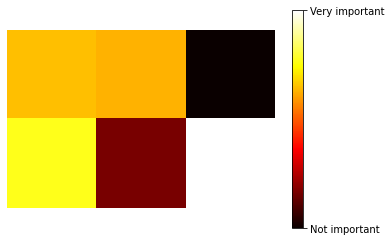

In [44]:
plot_digit(rnd_clf_grid_cv.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf_grid_cv.feature_importances_.min(), rnd_clf_grid_cv.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [45]:
for name, score in zip(column_names, rnd_clf_grid_cv.feature_importances_):
    print(name, score)

buying 0.19108464914698522
maint 0.18700415421988378
doors 0.052199855583440896
persons 0.21691317860254566
lug_boot 0.08726551616402714
safety 0.2655326462831173


As we see from plot and feature_importances_ classifier attribute value the most important features are `safety` and `persons`. `buying` and `maint` features are also rather meaningful.

<a id='Conclusion'></a>

## 9. Conclusion

- `RandomForestClassifier` has better result than `ExtraTreesClassifier`.
- Validation curves may be used to find an interval for `RandomizedSearchCV`, but they are of no real value.
- The best results gives consecutive usage of `RandomizedSearchCV` and `GridSearchCV`.
- The most important features are estimated safety of the car and capacity in terms of persons to carry.
- Tuning hyperparameters caused remarkable model quality improvement. 
- Random forest achieves great result even on imbalanced datasets.